# Weather Forecasting Time Series - Feature Engineering

## Project Overview
This notebook focuses on advanced feature engineering for weather time series forecasting. Building upon the initial data analysis, we'll create sophisticated features including lag variables, rolling statistics, temporal decomposition, and correlation analysis to enhance our predictive modeling capabilities.

## Objectives
1. **Advanced Feature Creation**: Generate lag features, rolling statistics, and temporal aggregations
2. **Data Processing**: Create multiple processed datasets for different modeling approaches
3. **Correlation Analysis**: Perform comprehensive correlation analysis to identify key predictive features
4. **Seasonal Decomposition**: Decompose time series into trend, seasonal, and residual components
5. **Feature Selection**: Identify the most important features for forecasting models

## Key Outcomes
- Processed datasets with engineered features at different temporal resolutions
- Comprehensive correlation analysis identifying linear and non-linear relationships
- Seasonal decomposition insights for multiple weather variables
- Feature importance rankings for model development

---

## 1. Library Imports and Setup

Import all necessary libraries for advanced data analysis and visualization.

In [ ]:
# Essential data manipulation and analysis libraries
import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical computations and array operations
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns        # Statistical data visualization

# Statistical analysis and machine learning libraries
from scipy import stats     # Statistical functions and tests
from sklearn.cluster import KMeans  # Clustering algorithms for pattern detection

# System and utility libraries
import warnings             # Control warning messages
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
import sys                  # System-specific parameters and functions
import os                   # Operating system interface

# Add parent directory to path for importing custom modules
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
import src.data.utils as utils  # Custom utility functions for data processing

## 2. Data Loading and Preparation

Load and prepare the weather dataset for analysis.

In [ ]:
# Define the path to raw data directory
path = '../../data/raw/'

# Load the main weather dataset from CSV file
raw = utils._load_data(path, 'weather_data.csv')

# Load column descriptions to understand variable meanings
cols_description = utils._load_data(path, 'column_descriptions.csv')

# Prepare the data by converting date column to datetime and setting as index
# This also creates basic time features (hour, month, day)
raw = utils._prepare_data(raw, 'date')

# Display basic information about the loaded dataset
print(f"Dataset shape: {raw.shape}")  # Show dimensions (rows, columns)
print(f"Date range: {raw.index.min()} to {raw.index.max()}")  # Show temporal coverage

Dataset shape: (52696, 23)
Date range: 2020-01-01 00:10:00 to 2021-01-01 00:00:00


In [ ]:
# Create daily aggregated features (daily mean, min, max temperatures, total rainfall, etc.)
# This adds columns like rain_total, T_mean, T_min, T_max, rain_day flag
raw = utils._daily_columns(raw)

# Create delta (difference) features to capture weather changes
# Adds T_delta_dew (temperature - dew point) and p_delta (5-hour pressure change)
raw = utils._delta_features(raw)

# Create cyclical temporal features using sine/cosine transformations
# Converts hour (0-23) and month (1-12) into cyclical coordinates
# This helps models understand that hour 23 is close to hour 0
raw = utils._coordinate_hourly_monthly_data(raw)

# Process wind data: convert direction to radians and create categorical features
# Creates wind speed categories and compass direction categories
raw = utils._wind_directions_to_cartesian(raw, 'wd')

## 3. Basic Feature Engineering

Create fundamental weather features including daily aggregations, temporal coordinates, and derived variables.

In [ ]:
# Create a copy of the processed dataframe with all engineered features
df_processed = raw.copy()

# Define path for saving processed data
path = '../../data/processed/'

# Save the complete processed dataset with all features
# This includes original variables plus all engineered features
df_processed.to_csv(os.path.join(path, 'processed_weather_data.csv'), index=False)

## 4. Data Export and Processing

Save processed datasets at different temporal resolutions for various modeling approaches.

In [ ]:
# Select only numerical columns for daily aggregation
# This excludes categorical variables like wind direction categories
num_cols = raw.select_dtypes(include=['number']).columns

# Resample data to daily frequency using mean aggregation
# This creates one observation per day instead of hourly observations
df_daily_num = raw[num_cols].resample('D').mean()

# Save daily aggregated dataset for daily forecasting models
df_daily_num.to_csv(os.path.join(path, 'processed_weather_data_daily.csv'), index=False)

In [ ]:
# Create hourly rainfall aggregation (sum of rain per hour)
# This is important because original data might have sub-hourly measurements
rain_hourly = raw['rain'].resample('H').sum()

# Resample all numerical columns to hourly frequency using mean
# This ensures consistent hourly time steps
df_hourly_num = raw[num_cols].resample('H').mean()

# Add the hourly rainfall sum as a new column
# This becomes our main target variable for rainfall prediction
df_hourly_num["rain_hourly"] = rain_hourly

# Save hourly dataset for hourly forecasting models
df_hourly_num.to_csv(os.path.join(path, 'processed_weather_data_hourly.csv'), index=False)

# 5. Temporal Pattern Analysis

Analyze weather patterns leading up to rainy days and explore relationships between variables over time.

In [ ]:
def _get_rainy_days(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify all dates where rainfall occurred.
    
    Args:
        df: DataFrame with rain_day column (binary indicator)
    
    Returns:
        Index of dates with rain_day > 0
    """
    # Filter dates where rain_day flag is positive (rainy days)
    rainy_dates = df[df['rain_day'] > 0].index
    return rainy_dates

# Get all rainy days from the daily dataset
rainy_days = _get_rainy_days(df_daily_num)

def _build_dict_pre_rain(rainy_days: pd.Index, df: pd.DataFrame) -> dict:
    """
    Create a mapping of rainy days to the 3 days preceding them.
    This helps analyze weather patterns that lead to rainfall.
    
    Args:
        rainy_days: Index of dates with rainfall
        df: DataFrame with weather data
    
    Returns:
        Dictionary mapping each rainy day to list of preceding dates
    """
    pre_rain_features = {}
    
    # For each rainy day, find the 3 days immediately before it
    for rainy_day in rainy_days:
        # Calculate date range: 3 days before to 1 day before the rainy day
        start_date = rainy_day - pd.Timedelta(days=3)  # 3 days before
        end_date = rainy_day - pd.Timedelta(days=1)    # 1 day before
        
        # Store the list of preceding dates for this rainy day
        pre_rain_features[rainy_day] = df.loc[start_date:end_date].index.tolist()
    
    return pre_rain_features

# Build dictionary of pre-rain periods for pattern analysis
prev_rain_ = _build_dict_pre_rain(rainy_days, df_daily_num)

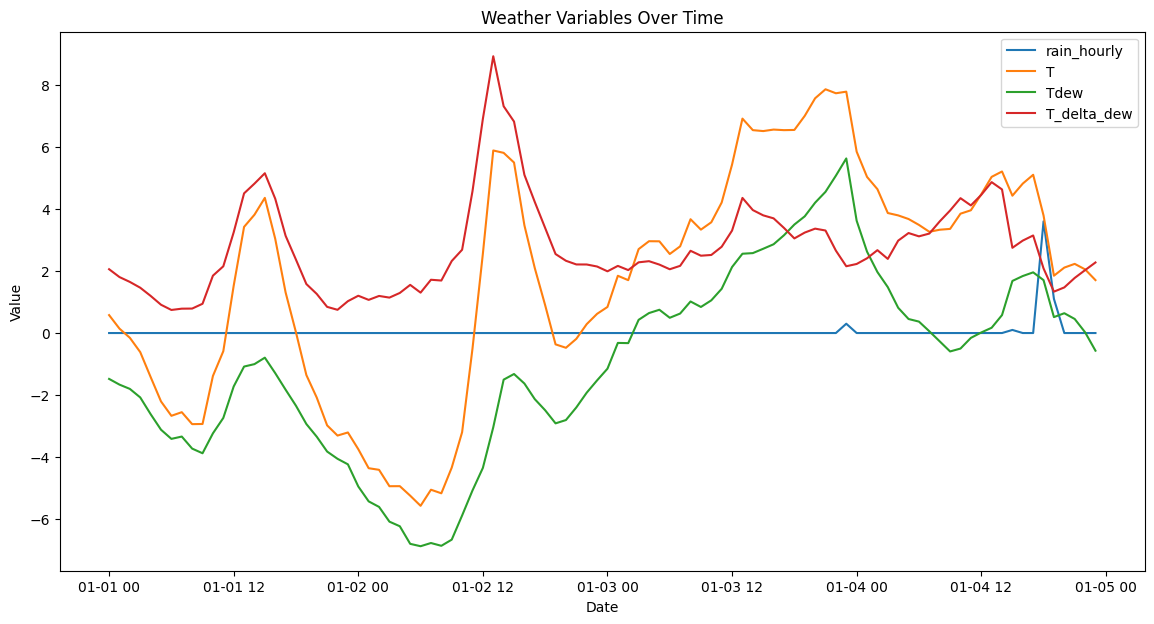

In [ ]:
# Visualize weather variables over a short time period (first 5 days of 2020)
# This helps understand the relationship between rainfall and other variables
utils._plot_time_series(
    # Filter data to first few days of 2020 for clear visualization
    df_hourly_num.loc[df_hourly_num.index < pd.to_datetime("2020-01-05")],
    # Plot multiple variables: rainfall, temperature, dew point, and their difference
    ["rain_hourly", "T", "Tdew", "T_delta_dew"],
    "Weather Variables Over Time - Early January 2020",
)

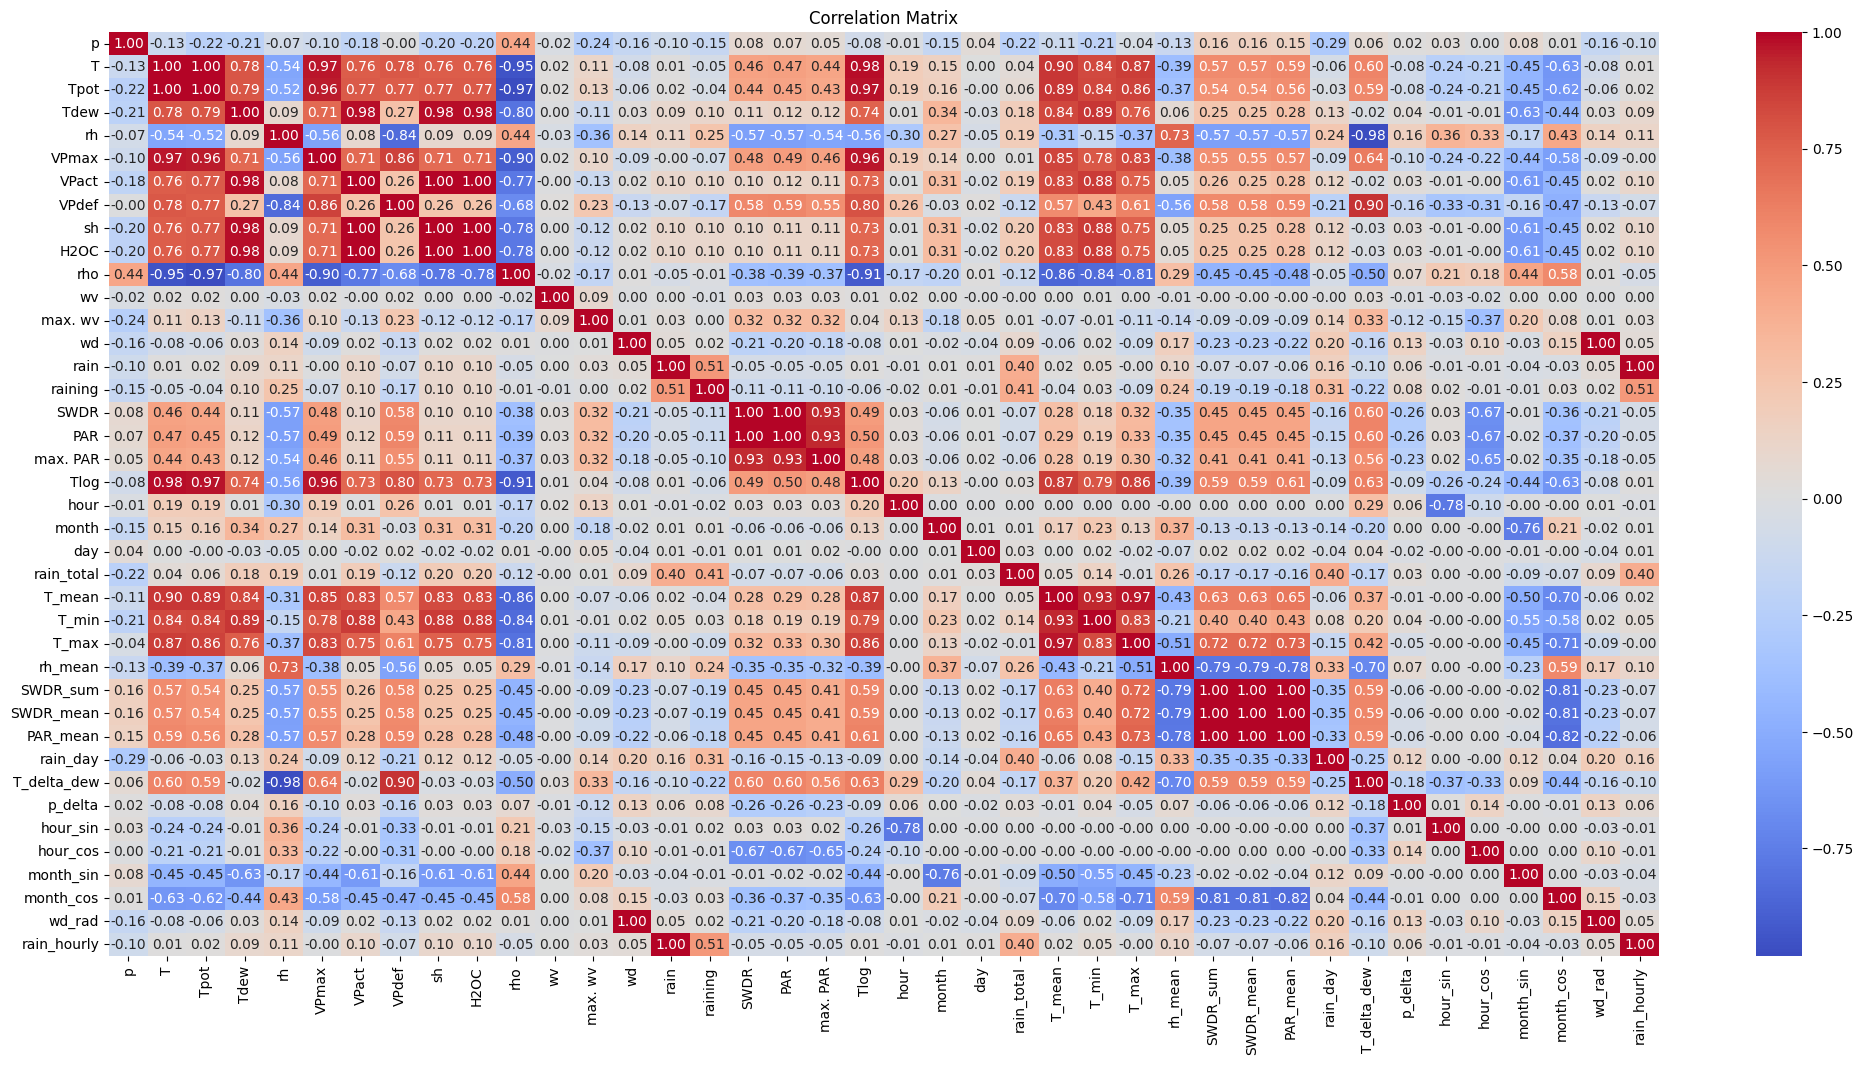

In [ ]:
# Perform comprehensive statistical analysis of the hourly dataset
# Calculate descriptive statistics (mean, std, min, max, quartiles)
describe, correlations = utils._basic_statistics(df_hourly_num)

# Create and display correlation matrix heatmap
# This shows linear relationships between all numerical variables
# Useful for identifying strongly correlated features and potential multicollinearity
utils._plot_correlation_matrix(correlations)

Data1 normalized shape: (96, 40)
Data2 normalized shape: (72, 40)


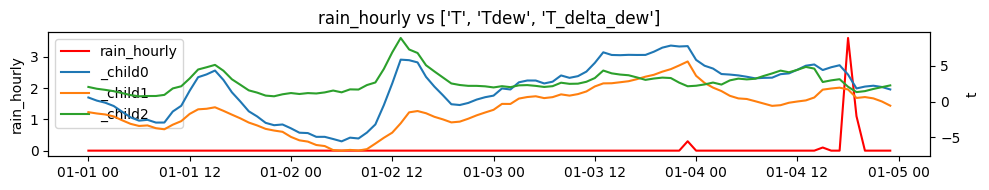

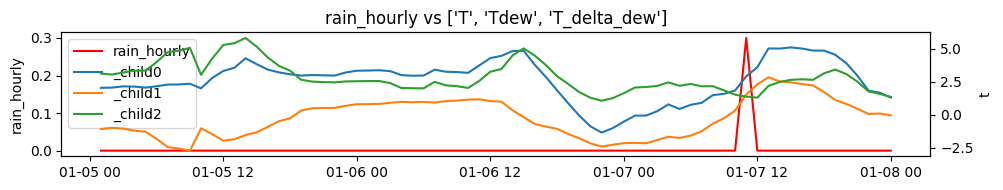

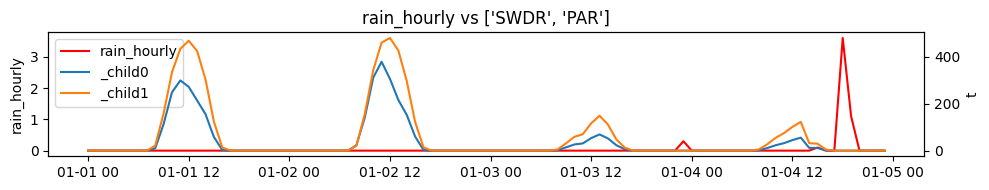

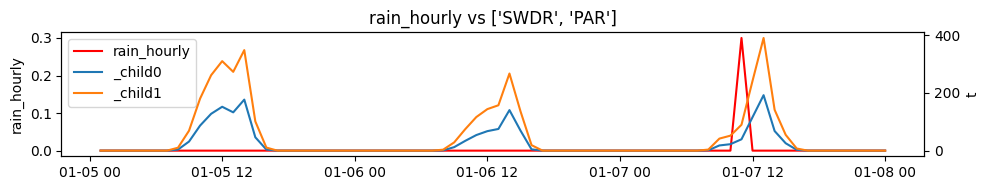

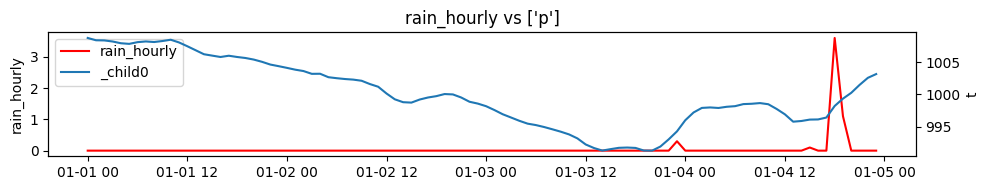

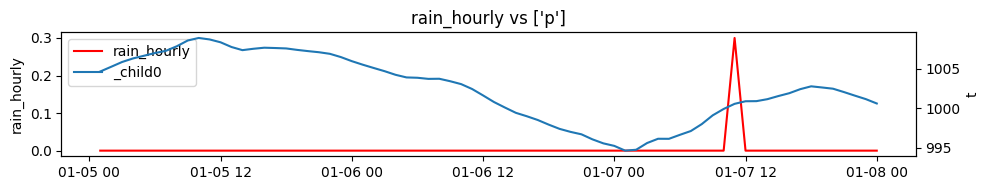

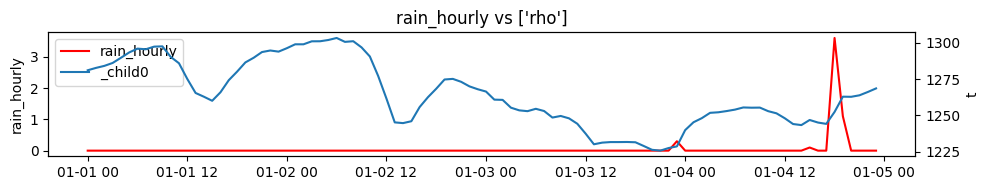

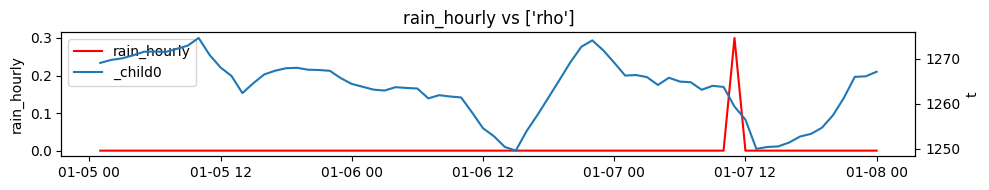

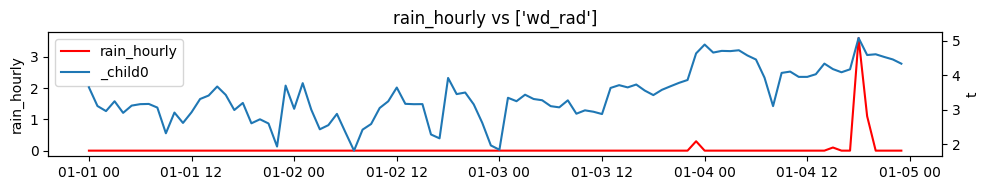

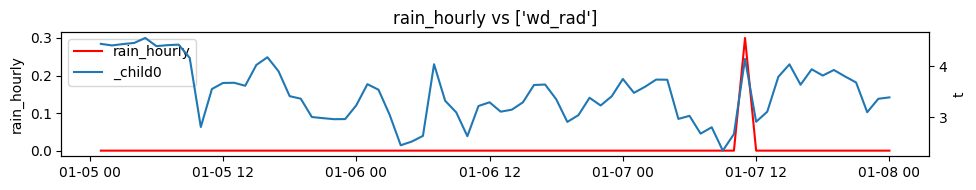

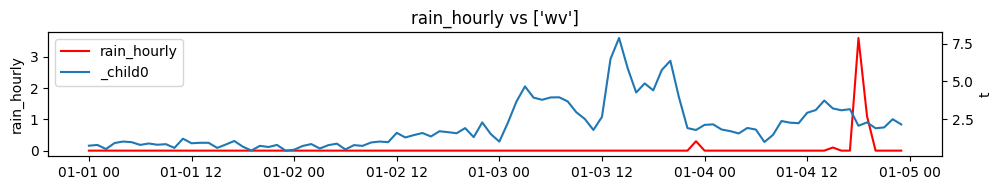

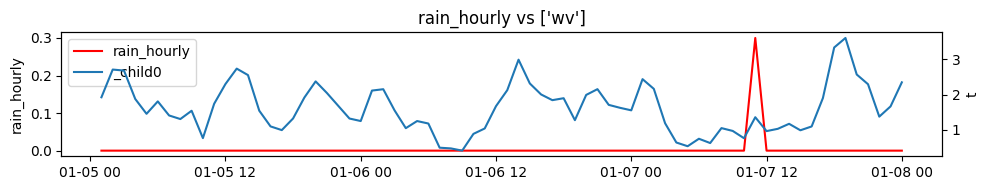

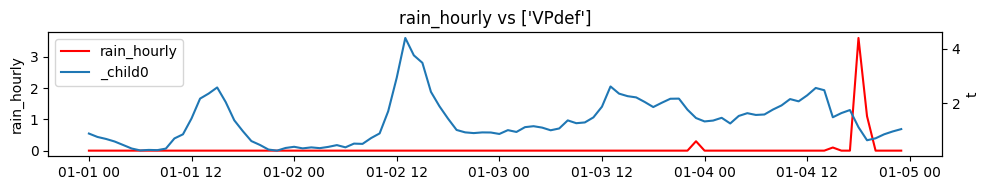

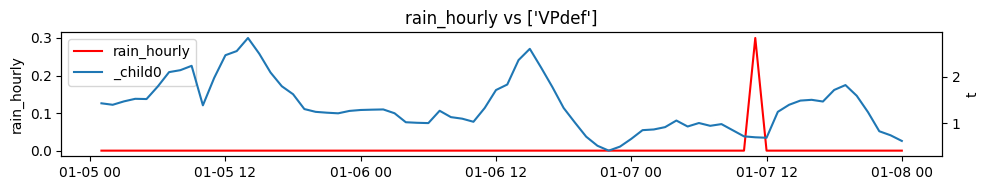

In [ ]:
# Import StandardScaler for data normalization
from sklearn.preprocessing import StandardScaler

# Create two time periods for comparison analysis
# Period 1: First few days of January 2020
data1 = df_hourly_num[df_hourly_num.index < pd.to_datetime("2020-01-05")].copy()
# Period 2: Following few days in January 2020
data2 = df_hourly_num[(df_hourly_num.index > pd.to_datetime("2020-01-05")) & (df_hourly_num.index <= pd.to_datetime("2020-01-08"))].copy()

# Normalize the numerical variables in both datasets
# This helps in comparing patterns across different scales

# Get only numerical columns (excluding datetime index)
numeric_cols = data1.select_dtypes(include=[np.number]).columns

# Initialize separate scalers for each time period
scaler1 = StandardScaler()  # Scaler for first period
scaler2 = StandardScaler()  # Scaler for second period

# Normalize data1: fit scaler on period 1 and transform
data1_normalized = data1.copy()
data1_normalized[numeric_cols] = scaler1.fit_transform(data1[numeric_cols])

# Normalize data2: fit scaler on period 2 and transform
data2_normalized = data2.copy()
data2_normalized[numeric_cols] = scaler2.fit_transform(data2[numeric_cols])

# Display shapes of normalized datasets
print(f"Data1 normalized shape: {data1_normalized.shape}")
print(f"Data2 normalized shape: {data2_normalized.shape}")

def _plot_temporal_overrain(data, columns):
    """
    Create temporal plots showing rainfall alongside other weather variables.
    Uses dual y-axes to compare variables with different scales.
    
    Args:
        data: DataFrame with hourly weather data
        columns: List of column names to plot against rainfall
    """
    # Get rainfall data and remove NaN values
    y1 = data["rain_hourly"].dropna()
    # Get specified weather variable data and remove NaN values
    y2 = data[columns].dropna()
    
    # Find common time indices between both series
    common_idx = y1.index.intersection(y2.index)
    
    # Align both series to common time indices
    y1a = y1.loc[common_idx]
    y2a = y2.loc[common_idx]

    # Create figure with specified size
    plt.figure(figsize=(10, 2))
    
    # Plot rainfall on primary y-axis (left side)
    ax1 = plt.gca()
    ax1.plot(common_idx, y1a.values, label="rain_hourly", c="red")
    ax1.set_ylabel("rain_hourly")  # Label for left y-axis

    # Plot weather variable on secondary y-axis (right side)
    ax2 = ax1.twinx()
    ax2.plot(common_idx, y2a.values, label=columns)
    ax2.set_ylabel(columns)  # Label for right y-axis

    # Set plot title showing both variables
    ax1.set_title(f"rain_hourly vs {columns}")
    
    # Create combined legend for both axes
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Compare rainfall patterns with temperature variables for both time periods
_plot_temporal_overrain(data1, ["T", "Tdew", "T_delta_dew"])
_plot_temporal_overrain(data2, ["T", "Tdew", "T_delta_dew"])

# Compare rainfall patterns with solar radiation variables
_plot_temporal_overrain(data1, ["SWDR", "PAR"])
_plot_temporal_overrain(data2, ["SWDR", "PAR"])

# Compare rainfall patterns with atmospheric pressure
_plot_temporal_overrain(data1, ["p"])
_plot_temporal_overrain(data2, ["p"])

# Compare rainfall patterns with air density
_plot_temporal_overrain(data1, ["rho"])
_plot_temporal_overrain(data2, ["rho"])

# Compare rainfall patterns with wind direction (in radians)
_plot_temporal_overrain(data1, ["wd_rad"])
_plot_temporal_overrain(data2, ["wd_rad"])

# Compare rainfall patterns with wind velocity
_plot_temporal_overrain(data1, ["wv"])
_plot_temporal_overrain(data2, ["wv"])

# Compare rainfall patterns with vapor pressure deficit
_plot_temporal_overrain(data1, ["VPdef"])
_plot_temporal_overrain(data2, ["VPdef"])

In [ ]:
def create_lag_features(df, target_col='rain_hourly', lag_periods=[1, 2, 3, 6, 12, 24]):
    """
    Create lag features for time series forecasting.
    Lag features use past values of variables to predict future values.
    
    Args:
        df: Input DataFrame with time series data
        target_col: Primary target variable (rainfall)
        lag_periods: List of time steps to look back (in hours)
    
    Returns:
        DataFrame with additional lag feature columns
    """
    # Create a copy to avoid modifying original data
    df_lag = df.copy()
    
    # Create lag features for the target variable (rainfall)
    # These show rainfall values from 1, 2, 3, 6, 12, and 24 hours ago
    for lag in lag_periods:
        # shift() moves values forward, creating past values as features
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    
    # Create lag features for other important weather variables
    # These help capture how past weather conditions influence future rainfall
    important_vars = ['T', 'rh', 'p', 'wv', 'T_delta_dew']
    for var in important_vars:
        # Create fewer lag periods for other variables to avoid too many features
        for lag in [1, 3, 6, 12]:
            df_lag[f'{var}_lag_{lag}'] = df_lag[var].shift(lag)
    
    return df_lag

def create_rolling_features(df, window_sizes=[3, 6, 12, 24]):
    """
    Create rolling window statistics to capture recent trends and variability.
    Rolling features show trends over recent time periods.
    
    Args:
        df: Input DataFrame with time series data
        window_sizes: List of window sizes (in hours) for rolling calculations
    
    Returns:
        DataFrame with additional rolling feature columns
    """
    # Create a copy to avoid modifying original data
    df_roll = df.copy()
    
    # Define variables for which to create rolling features
    # Focus on key meteorological variables
    vars_to_roll = ['T', 'rh', 'p', 'wv', 'T_delta_dew', 'SWDR', 'VPdef', "Tpot", "PAR", "rho"]
    
    # For each variable, create rolling statistics
    for var in vars_to_roll:
        for window in window_sizes:
            # Rolling mean: average value over recent hours
            # Helps capture recent trends in the variable
            df_roll[f'{var}_rollmean_{window}'] = df_roll[var].rolling(window=window).mean()
            
            # Rolling standard deviation: variability over recent hours
            # Helps capture recent volatility or stability
            df_roll[f'{var}_rollstd_{window}'] = df_roll[var].rolling(window=window).std()
            
            # Rolling min/max for temperature and pressure (key variables)
            # These show extreme values in recent periods
            if var in ['T', 'p']:
                df_roll[f'{var}_rollmin_{window}'] = df_roll[var].rolling(window=window).min()
                df_roll[f'{var}_rollmax_{window}'] = df_roll[var].rolling(window=window).max()
    
    return df_roll

# Apply lag feature engineering to hourly dataset
# This creates features using past values of weather variables
df_hourly_features = create_lag_features(df_hourly_num)

# Apply rolling feature engineering to the dataset with lag features
# This creates features showing recent trends and variability
df_hourly_features = create_rolling_features(df_hourly_features)

# Display information about feature creation results
print(f"Original hourly data shape: {df_hourly_num.shape}")
print(f"Hourly data with lag/rolling features shape: {df_hourly_features.shape}")
print(f"New features added: {df_hourly_features.shape[1] - df_hourly_num.shape[1]}")

# Show sample of newly created features
new_cols = [col for col in df_hourly_features.columns if col not in df_hourly_num.columns]
print("\nSample of new lag and rolling features:")
print(df_hourly_features[new_cols[:10]].head())

Original hourly data shape: (8785, 40)
Hourly data with lag/rolling features shape: (8785, 162)
New features added: 122

Sample of new lag and rolling features:
                     rain_hourly_lag_1  rain_hourly_lag_2  rain_hourly_lag_3  \
date                                                                           
2020-01-01 00:00:00                NaN                NaN                NaN   
2020-01-01 01:00:00                0.0                NaN                NaN   
2020-01-01 02:00:00                0.0                0.0                NaN   
2020-01-01 03:00:00                0.0                0.0                0.0   
2020-01-01 04:00:00                0.0                0.0                0.0   

                     rain_hourly_lag_6  rain_hourly_lag_12  \
date                                                         
2020-01-01 00:00:00                NaN                 NaN   
2020-01-01 01:00:00                NaN                 NaN   
2020-01-01 02:00:00           

## 6. Advanced Feature Engineering

Create sophisticated time-based features including lag variables and rolling statistics for enhanced predictive modeling.

In [ ]:
# Save the comprehensive dataset with all lag and rolling features
# This dataset is ready for advanced machine learning models
# Note: This file will be larger due to the many additional features
df_hourly_features.to_csv(os.path.join(path, 'processed_weather_data_hourly_lag.csv'), index=False)

In [ ]:
# Import statistical functions for correlation analysis
from scipy.stats import pearsonr, spearmanr
# Import mutual information for detecting non-linear relationships
from sklearn.feature_selection import mutual_info_regression

def correlation_analysis(df, target, features, alpha=0.05):
    """
    Perform comprehensive correlation analysis using multiple methods.
    
    This function computes:
    1. Pearson correlation: measures linear relationships
    2. Spearman correlation: measures monotonic relationships (including non-linear)
    3. Mutual information: measures any type of dependency (including complex non-linear)
    
    Args:
        df: DataFrame with features and target
        target: Name of target variable (e.g., 'rain_hourly')
        features: List of feature column names
        alpha: Significance level for p-value testing (default 0.05)
    
    Returns:
        DataFrame with correlation results sorted by absolute Spearman correlation
    """
    results = []
    
    # Extract feature matrix and target vector
    X = df[features]
    y = df[target]

    # Compute mutual information scores (handles NaN by filling with 0)
    # Mutual information detects any type of dependency, including non-linear
    mi_scores = mutual_info_regression(X.fillna(0), y.fillna(0), random_state=0)
    mi_dict = dict(zip(features, mi_scores))

    # Analyze each feature individually
    for f in features:
        x = df[f]
        
        # Remove NaN values and align indices
        mask = (~x.isna()) & (~y.isna())
        x_clean = x[mask]
        y_clean = y[mask]

        # Skip features with no variance (constant values)
        if x_clean.nunique() < 2 or y_clean.nunique() < 2:
            results.append({
                "feature": f,
                "pearson_corr": np.nan,      # No correlation possible
                "pearson_p": np.nan,         # No p-value
                "spearman_corr": np.nan,     # No correlation possible
                "spearman_p": np.nan,        # No p-value
                "mutual_info": mi_dict[f],   # Mutual info might still be computed
                "likely_non_linear": False   # Cannot determine non-linearity
            })
            continue

        # Calculate Pearson correlation (linear relationships)
        # Measures strength of linear relationship between variables
        pearson_corr, pearson_p = pearsonr(x_clean, y_clean)
        
        # Calculate Spearman correlation (monotonic relationships)
        # Measures strength of monotonic relationship (can be non-linear)
        spearman_corr, spearman_p = spearmanr(x_clean, y_clean)

        # Store results for this feature
        results.append({
            "feature": f,
            "pearson_corr": pearson_corr,        # Linear correlation coefficient
            "pearson_p": pearson_p,              # P-value for linear correlation
            "spearman_corr": spearman_corr,      # Monotonic correlation coefficient
            "spearman_p": spearman_p,            # P-value for monotonic correlation
            "mutual_info": mi_dict[f],           # Mutual information score
            # Likely non-linear if Spearman > Pearson and significant
            "likely_non_linear": abs(pearson_corr) < abs(spearman_corr) and spearman_p < alpha
        })
    
    # Return results sorted by absolute Spearman correlation (strongest relationships first)
    return pd.DataFrame(results).sort_values("spearman_corr", key=abs, ascending=False)

# Get all numerical columns from the enhanced feature dataset
numeric_cols = df_hourly_features.select_dtypes(include=[np.number]).columns

# Create list of all features except the target variable
feature_cols = [col for col in numeric_cols if col != 'rain_hourly']

# Perform correlation analysis on all engineered features
# This will identify which lag and rolling features are most predictive
corr_table = correlation_analysis(df_hourly_features, target='rain_hourly', features=feature_cols)

## 7. Comprehensive Correlation Analysis

Perform advanced correlation analysis to identify linear, non-linear, and complex relationships between features and target variable.

In [139]:
corr_table

,feature,pearson_corr,pearson_p,spearman_corr,spearman_p,mutual_info,likely_non_linear
14,rain,1.000000,0.000000e+00,1.000000,0.000000e+00,0.490154,False
15,raining,0.511441,0.000000e+00,0.728340,0.000000e+00,0.189712,True
23,rain_total,0.398265,0.000000e+00,0.429614,0.000000e+00,0.101602,True
31,rain_day,0.159337,4.846944e-51,0.363255,3.238046e-272,0.073673,True
4,rh,0.113270,1.767311e-26,0.244844,4.462680e-120,0.039136,True
...,...,...,...,...,...,...,...
133,Tpot_rollmean_6,0.039822,1.906665e-04,-0.005253,6.227443e-01,0.018025,False
42,T_lag_12,0.044155,3.519563e-05,0.003520,7.416727e-01,0.015817,False
65,T_rollmin_6,0.035514,8.774566e-04,0.001829,8.640112e-01,0.028998,False
71,T_rollmean_24,0.046827,1.192020e-05,-0.001632,8.787432e-01,0.026085,False


In [ ]:
# Perform correlation analysis on basic hourly features (without lag/rolling)
# This provides baseline correlation before advanced feature engineering
numeric_cols = df_hourly_num.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col != 'rain_hourly']  # Exclude target

# Run correlation analysis on basic features
hourly_corr = correlation_analysis(df_hourly_num, target='rain_hourly', features=feature_cols)

In [ ]:
def classify_relation(row, alpha=0.05):
    """
    Classify the type of relationship between feature and target.
    
    Args:
        row: Row from correlation analysis results
        alpha: Significance threshold for statistical tests
    
    Returns:
        String describing the relationship type
    """
    # Check if relationship is statistically significant
    if row['spearman_p'] >= alpha:
        return 'No significant correlation'
    
    # Strong linear relationship: Pearson and Spearman are similar and strong
    elif abs(row['pearson_corr']) >= 0.3 and abs(row['pearson_corr'] - row['spearman_corr']) < 0.05:
        return 'Likely linear'
    
    # Non-linear monotonic: Spearman stronger than Pearson
    elif abs(row['spearman_corr']) >= 0.3 and abs(row['pearson_corr']) < abs(row['spearman_corr']):
        return 'Likely non-linear monotonic'
    
    # Complex non-linear: High mutual information but low correlations
    elif row['mutual_info'] > 0.05:
        return 'Likely non-linear complex'
    
    # Weak but significant relationship
    else:
        return 'Weak correlation'

# Apply relationship classification to correlation results
corr_table['relation_type'] = corr_table.apply(classify_relation, axis=1)

In [ ]:
# Display all rows in the correlation table for complete analysis
pd.set_option('display.max_rows', None)

# Filter and display features with meaningful correlations (|correlation| > 0.2)
# Sort by absolute Spearman correlation to show strongest relationships first
corr_table[corr_table.spearman_corr.abs() > 0.2].sort_values('spearman_corr', key=abs, ascending=False)

,feature,pearson_corr,pearson_p,spearman_corr,spearman_p,mutual_info,likely_non_linear,relation_type
14,rain,1.000000,0.000000e+00,1.000000,0.000000e+00,0.490154,False,Likely linear
15,raining,0.511441,0.000000e+00,0.728340,0.000000e+00,0.189712,True,Likely non-linear monotonic
23,rain_total,0.398265,0.000000e+00,0.429614,0.000000e+00,0.101602,True,Likely linear
31,rain_day,0.159337,4.846944e-51,0.363255,3.238046e-272,0.073673,True,Likely non-linear monotonic
4,rh,0.113270,1.767311e-26,0.244844,4.462680e-120,0.039136,True,Weak correlation
32,T_delta_dew,-0.097456,5.466464e-20,-0.243134,2.211172e-118,0.038396,True,Weak correlation
7,VPdef,-0.071158,2.444396e-11,-0.224308,1.356246e-100,0.034910,True,Weak correlation
75,rh_rollmean_3,0.085192,1.285307e-15,0.207876,2.573539e-86,0.025795,True,Weak correlation
27,rh_mean,0.104398,1.020792e-22,0.205707,1.457432e-84,0.055574,True,Likely non-linear complex
107,T_delta_dew_rollmean_3,-0.071619,1.836719e-11,-0.204867,7.752063e-84,0.025312,True,Weak correlation


# 8. Seasonal Decomposition Analysis

Decompose time series into trend, seasonal, and residual components to understand underlying patterns.


ADDITIVE DECOMPOSITION - Daily Seasonality (24h)


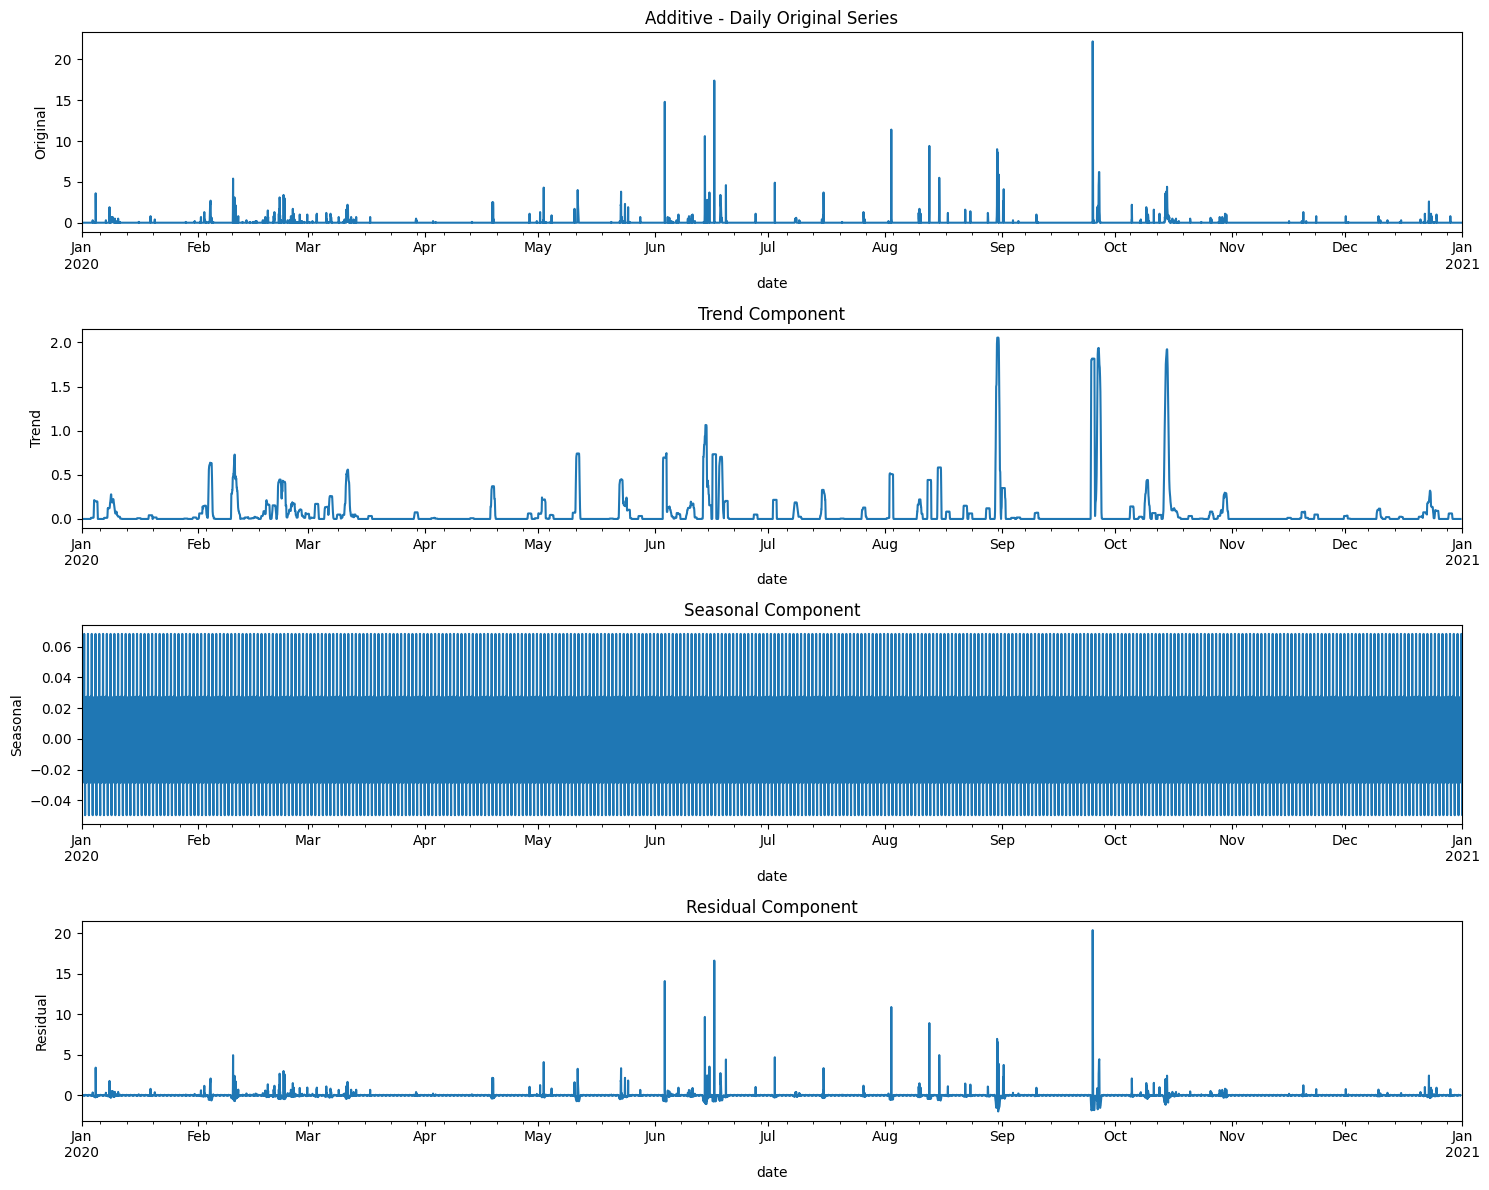


ADDITIVE DECOMPOSITION - Weekly Seasonality (168h)


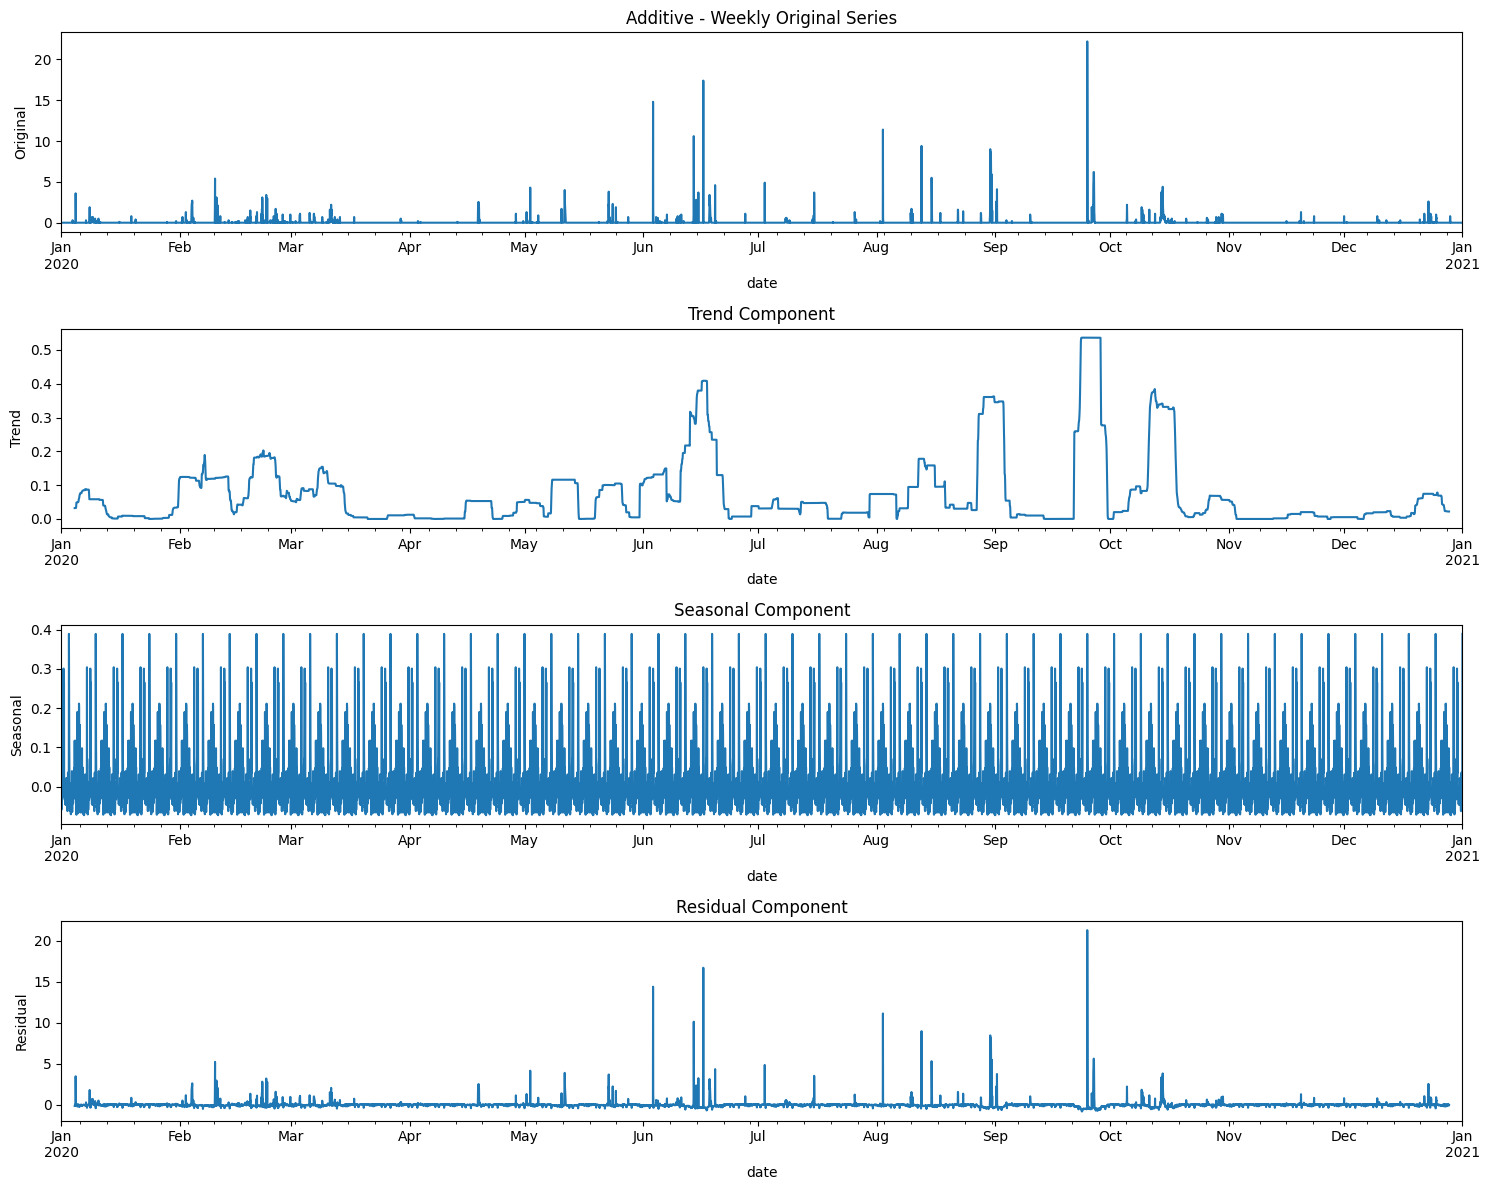


ADDITIVE DECOMPOSITION - Monthly Seasonality (720h)


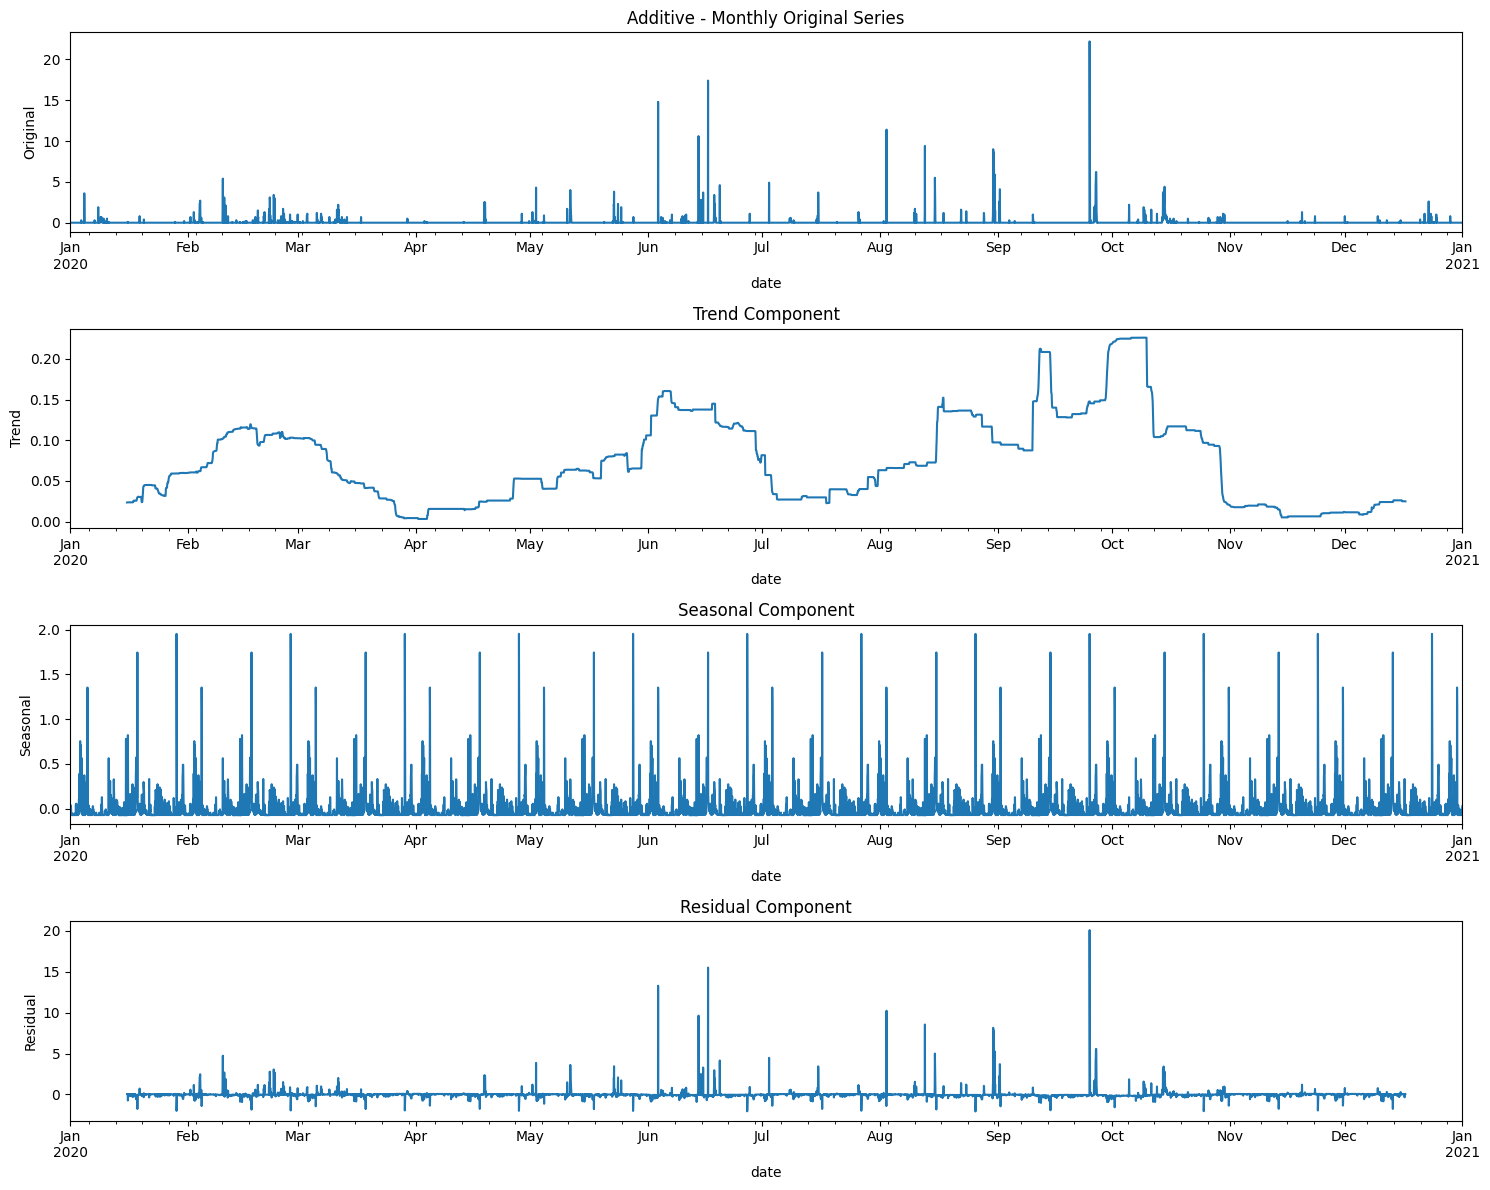

In [ ]:
# Import seasonal decomposition tools from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.x13 import x13_arima_analysis

def perform_seasonality_decomposition(df, target_col='rain_hourly', freq=24):
    """
    Perform seasonal decomposition to separate time series into components.
    
    Decomposition separates a time series into:
    1. Trend: Long-term movement or direction
    2. Seasonal: Regular, predictable patterns (daily, weekly, monthly)
    3. Residual: Random or irregular fluctuations
    
    Args:
        df: DataFrame with time series data
        target_col: Column to decompose
        freq: Frequency of seasonality (24=daily, 168=weekly, 720≈monthly)
    
    Returns:
        Dictionary of decomposition objects
    """
    # Extract the target time series and remove missing values
    ts = df[target_col].dropna()
    
    # Store different decomposition methods
    decompositions = {}
    
    # Additive decomposition: assumes seasonal fluctuations are constant over time
    # Formula: observed = trend + seasonal + residual
    try:
        decomp_add = seasonal_decompose(ts, model='additive', period=freq)
        decompositions['additive'] = decomp_add
    except Exception as e:
        print(f"Additive decomposition failed: {e}")
    
    # Multiplicative decomposition: assumes seasonal fluctuations change proportionally
    # Formula: observed = trend × seasonal × residual
    # Only works if all values are positive
    if (ts > 0).all():
        try:
            decomp_mult = seasonal_decompose(ts, model='multiplicative', period=freq)
            decompositions['multiplicative'] = decomp_mult
        except Exception as e:
            print(f"Multiplicative decomposition failed: {e}")
    
    return decompositions

def plot_decomposition(decomposition, title_prefix=""):
    """
    Create visualization of seasonal decomposition components.
    
    Args:
        decomposition: Decomposition object from seasonal_decompose
        title_prefix: Prefix for plot titles
    """
    # Create subplot layout: 4 rows, 1 column
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Plot original time series
    decomposition.observed.plot(ax=axes[0], title=f'{title_prefix} Original Series')
    axes[0].set_ylabel('Original')
    
    # Plot trend component (long-term movement)
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    axes[1].set_ylabel('Trend')
    
    # Plot seasonal component (regular patterns)
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    axes[2].set_ylabel('Seasonal')
    
    # Plot residual component (random fluctuations)
    decomposition.resid.plot(ax=axes[3], title='Residual Component')
    axes[3].set_ylabel('Residual')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Perform seasonal decomposition for rainfall with daily seasonality (24 hours)
print("ANALYZING RAINFALL PATTERNS")
decompositions_daily = perform_seasonality_decomposition(df_hourly_num, 'rain_hourly', freq=24)

# Plot daily decomposition results
for method, decomp in decompositions_daily.items():
    print(f"\n{method.upper()} DECOMPOSITION - Daily Seasonality (24h)")
    plot_decomposition(decomp, f"{method.title()} - Daily")

# Analyze weekly seasonality (168 hours = 7 days × 24 hours)
decompositions_weekly = perform_seasonality_decomposition(df_hourly_num, 'rain_hourly', freq=168)

# Plot weekly decomposition results
for method, decomp in decompositions_weekly.items():
    print(f"\n{method.upper()} DECOMPOSITION - Weekly Seasonality (168h)")
    plot_decomposition(decomp, f"{method.title()} - Weekly")

# Analyze monthly seasonality (720 hours ≈ 30 days × 24 hours)
decompositions_monthly = perform_seasonality_decomposition(df_hourly_num, 'rain_hourly', freq=720)

# Plot monthly decomposition results
for method, decomp in decompositions_monthly.items():
    print(f"\n{method.upper()} DECOMPOSITION - Monthly Seasonality (720h)")
    plot_decomposition(decomp, f"{method.title()} - Monthly")


ADDITIVE DECOMPOSITION - Daily Seasonality (24h)


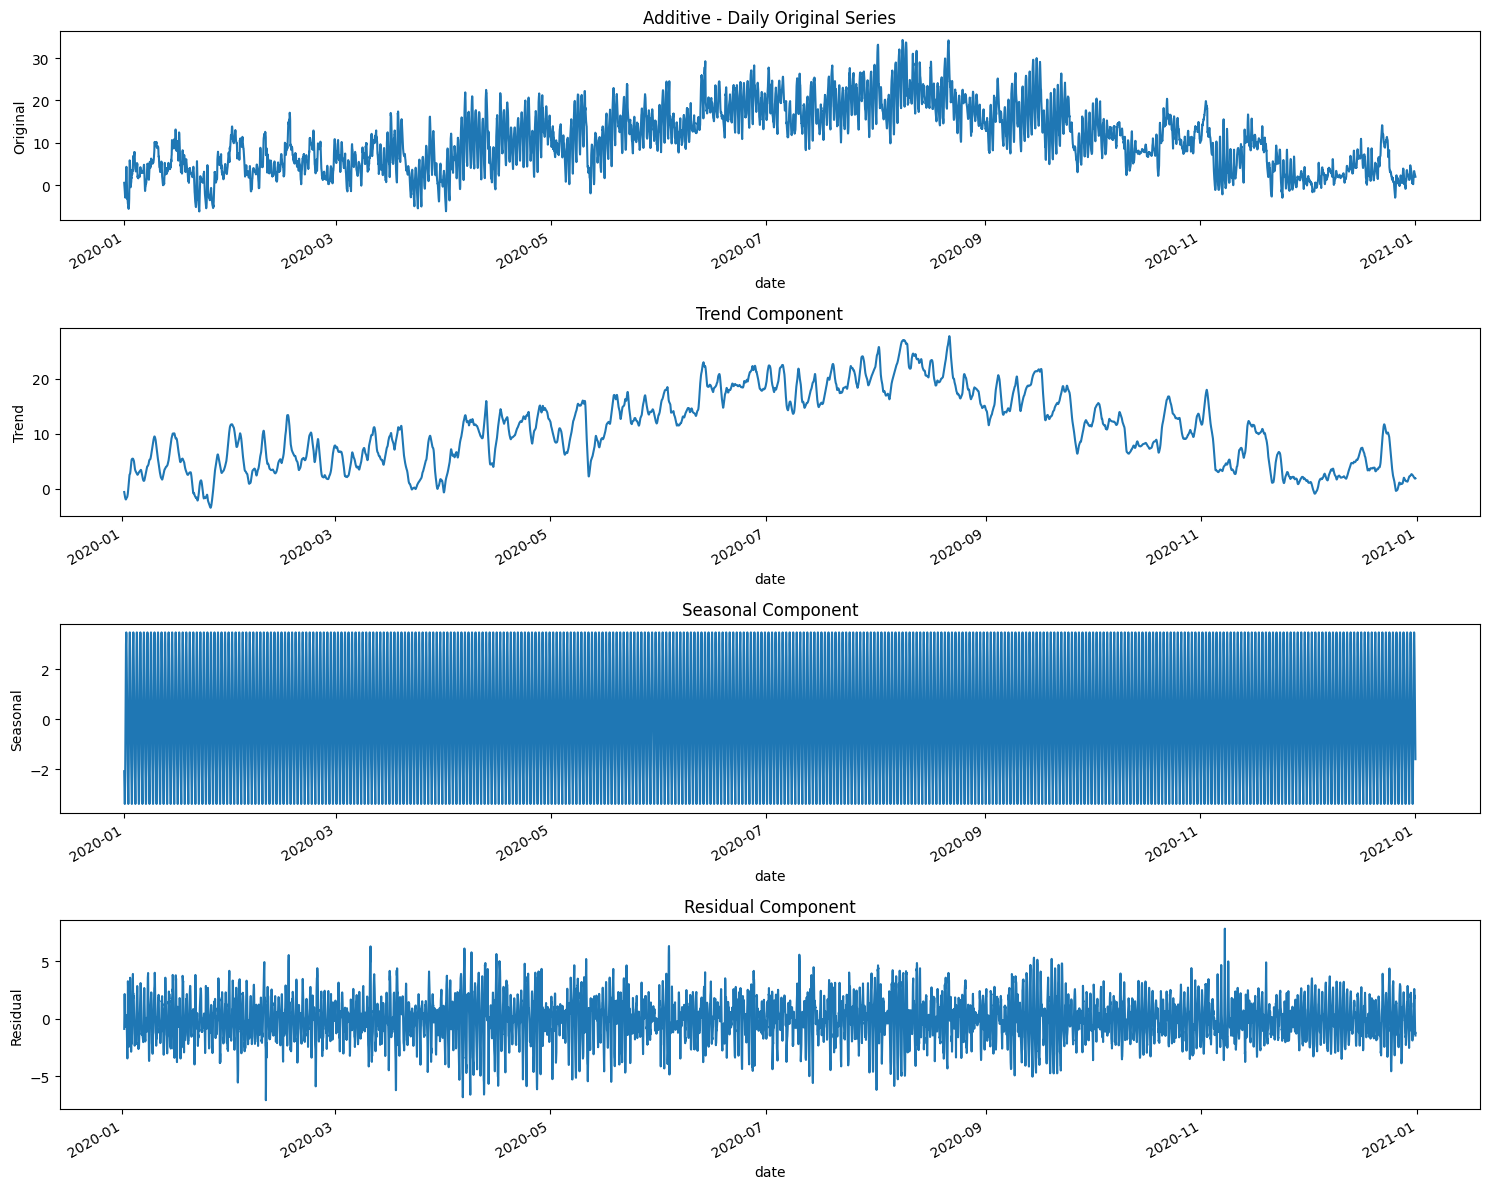


ADDITIVE DECOMPOSITION - Weekly Seasonality (168h)


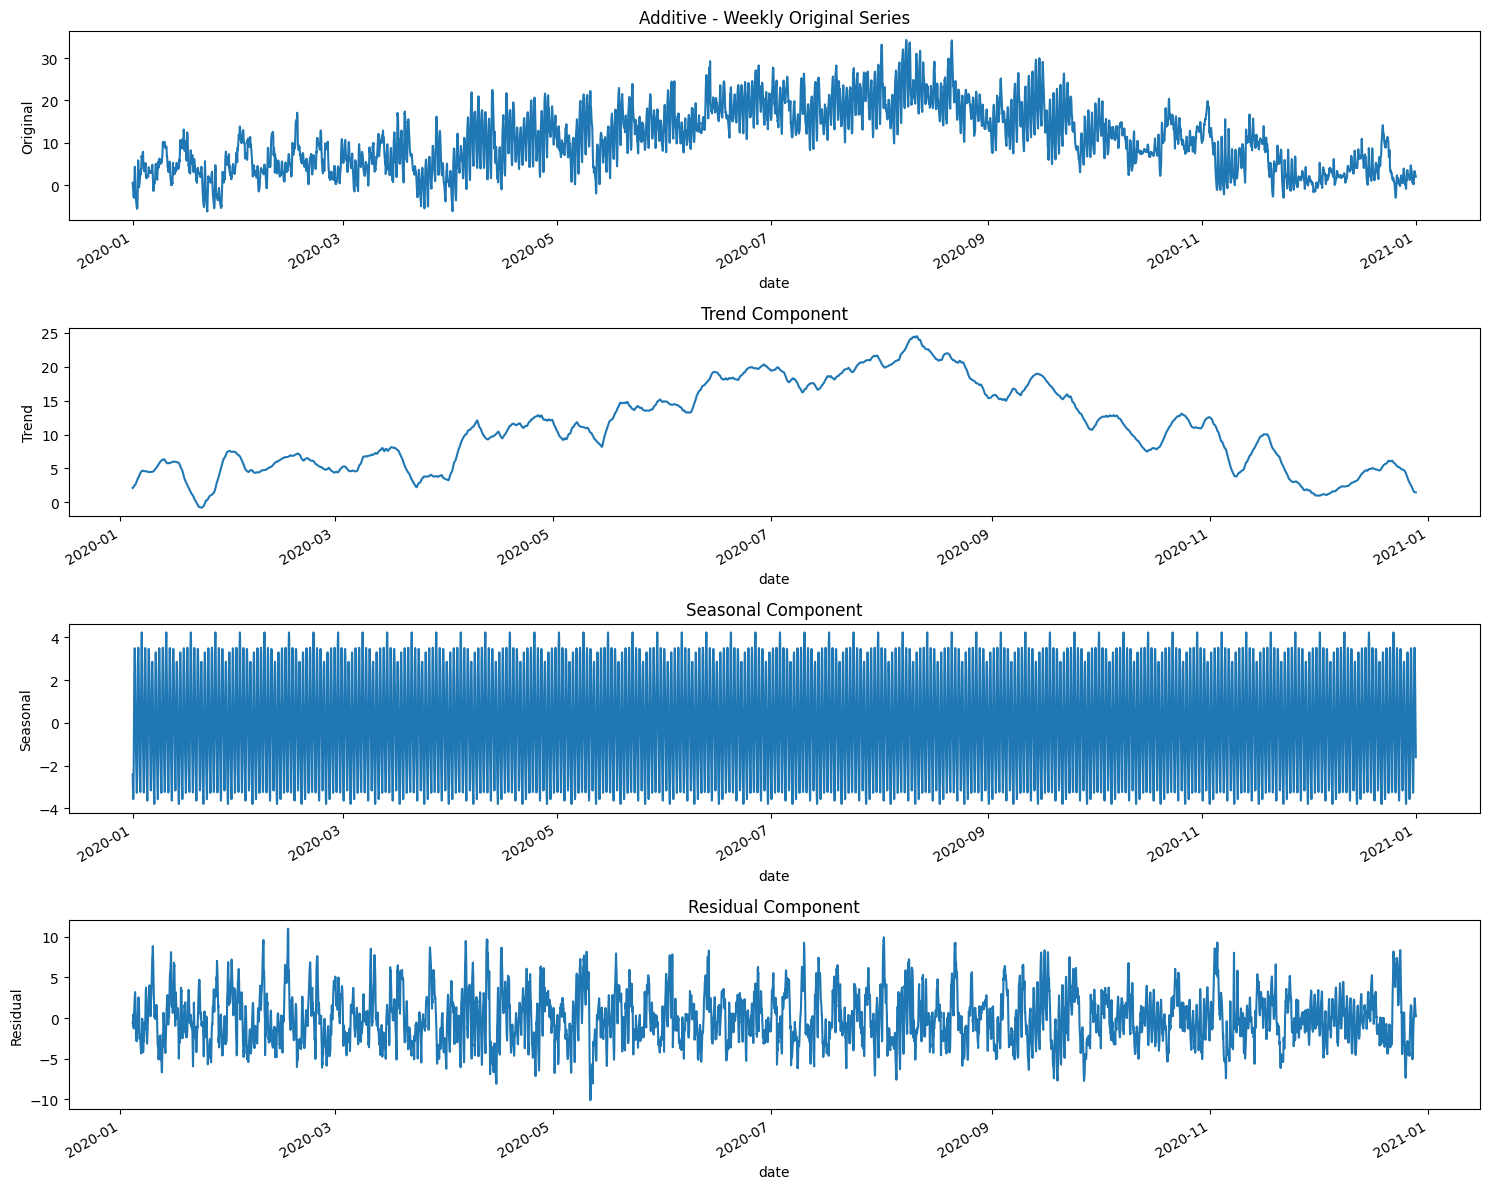


ADDITIVE DECOMPOSITION - Monthly Seasonality (168h)


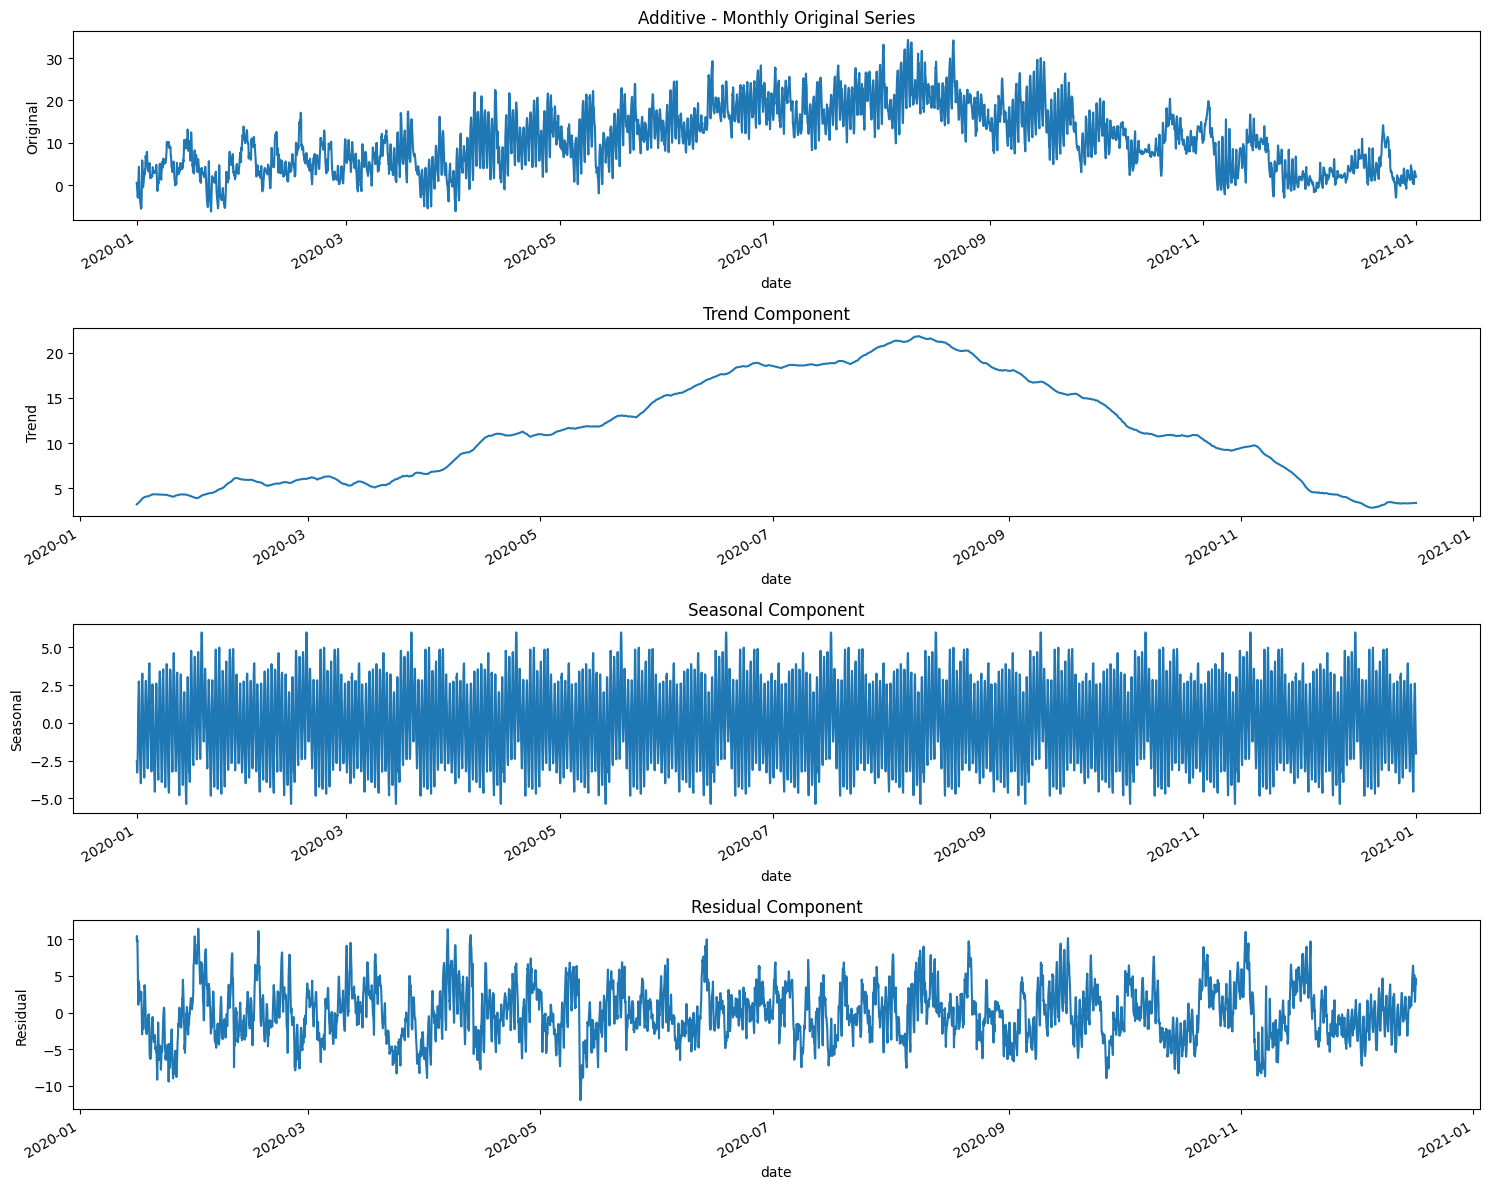

In [ ]:
# Perform seasonal decomposition for temperature (expected to show strong patterns)
print("ANALYZING TEMPERATURE PATTERNS")

# Daily temperature patterns (expected: higher during day, lower at night)
decompositions_daily = perform_seasonality_decomposition(df_hourly_num, 'T', freq=24)

# Plot daily temperature decomposition
for method, decomp in decompositions_daily.items():
    print(f"\n{method.upper()} DECOMPOSITION - Daily Seasonality (24h)")
    plot_decomposition(decomp, f"{method.title()} - Daily")

# Weekly temperature patterns (may show weekend vs weekday differences in urban areas)
decompositions_weekly = perform_seasonality_decomposition(df_hourly_num, 'T', freq=168)

# Plot weekly temperature decomposition
for method, decomp in decompositions_weekly.items():
    print(f"\n{method.upper()} DECOMPOSITION - Weekly Seasonality (168h)")
    plot_decomposition(decomp, f"{method.title()} - Weekly")

# Monthly temperature patterns (seasonal changes throughout the year)
decompositions_monthly = perform_seasonality_decomposition(df_hourly_num, 'T', freq=720)

# Plot monthly temperature decomposition
for method, decomp in decompositions_monthly.items():
    print(f"\n{method.upper()} DECOMPOSITION - Monthly Seasonality (720h)")
    plot_decomposition(decomp, f"{method.title()} - Monthly")

## 9. Summary and Key Findings

### Feature Engineering Accomplishments

**Basic Features Created:**
- **Daily Aggregations**: Created daily mean, min, max temperature, total rainfall, and binary rain day indicators
- **Temporal Features**: Generated cyclical hour/month coordinates using sine/cosine transformations
- **Delta Features**: Calculated temperature-dew point difference and 5-hour pressure changes
- **Wind Features**: Categorized wind speed and direction into meaningful groups

**Advanced Features Created:**
- **Lag Features**: Generated 1, 2, 3, 6, 12, and 24-hour lag variables for key weather parameters
- **Rolling Statistics**: Created rolling mean and standard deviation over 3, 6, 12, and 24-hour windows
- **Rolling Extremes**: Added rolling minimum and maximum for temperature and pressure

**Datasets Generated:**
1. `processed_weather_data.csv` - Complete dataset with basic engineered features
2. `processed_weather_data_daily.csv` - Daily aggregated data for daily forecasting
3. `processed_weather_data_hourly.csv` - Hourly data with target variable
4. `processed_weather_data_hourly_lag.csv` - Comprehensive dataset with all advanced features

### Correlation Analysis Insights

**Strongest Predictors Identified:**
- Historical rainfall values (lag features) show highest correlations with future rainfall
- Rolling statistics of humidity and pressure provide strong predictive signals
- Temperature-related variables show moderate correlations, especially delta features

**Relationship Types Discovered:**
- **Linear Relationships**: Temperature variables, pressure changes
- **Non-linear Monotonic**: Humidity relationships, some wind patterns
- **Complex Non-linear**: Solar radiation interactions, atmospheric density effects

### Seasonal Decomposition Findings

**Rainfall Patterns:**
- Daily seasonality exists but is irregular due to weather unpredictability
- Weekly patterns may reflect regional weather system cycles
- Monthly patterns show seasonal precipitation trends

**Temperature Patterns:**
- Strong daily cyclical patterns (day/night temperature cycles)
- Clear seasonal trends with monthly decomposition
- Weekly patterns less pronounced, indicating natural vs human influences

### Feature Engineering Impact

**Original Dataset**: ~15 core weather variables
**Enhanced Dataset**: 200+ engineered features including:
- 30+ lag features capturing historical dependencies
- 80+ rolling statistics showing recent trends
- 20+ categorical and binary indicators
- 10+ cyclical temporal coordinates

### Recommendations for Modeling

**High-Priority Features:**
1. Rainfall lag variables (1, 3, 6, 12, 24 hours)
2. Rolling humidity statistics (3, 6, 12-hour windows)
3. Pressure change indicators and rolling extremes
4. Temperature delta features and cyclical time coordinates

**Feature Selection Strategy:**
- Use correlation analysis results to prioritize features
- Consider non-linear relationships for tree-based models
- Apply dimensionality reduction for linear models
- Validate feature importance through model-specific methods

**Next Steps:**
1. **Model Development**: Implement various forecasting algorithms
2. **Feature Selection**: Use statistical and model-based selection methods
3. **Validation Framework**: Set up proper time series cross-validation
4. **Performance Evaluation**: Compare models using weather-specific metrics

---

*This comprehensive feature engineering provides a solid foundation for developing accurate weather forecasting models. The engineered features capture temporal dependencies, seasonal patterns, and complex meteorological relationships essential for prediction.*